# Data Loading, Clustering, and Machine Learning Predictions

## Preliminaries

### Summary

In this class we will be using a publicly available dataset to perform some data analysis.
We will start by loading the dataset and inspecting it, then we will move onto the explanation of how to perform effective clustering on some data features to prepare the data for predictive modelling. Finally, we will employ Machine Learning (ML) models to perform regression and classification experiments. We will give an overview on the best practices and how to handle data for similar applications.

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### PM100 Dataset

PM100 is a dataset available at https://zenodo.org/records/10127767. The dataset comprises the data of more than **230K job executed on Marconi100 supercomputer**. A job is a **user-submitted request** to execute a specific computational task on an HPC system. These jobs are managed by a scheduler, which allocates the necessary resources—such as CPU cores, memory, and time—based on availability and predefined policies. This ensures efficient and fair utilization of the HPC infrastructure.

Each entry contains information job executions (i.e., a computational task executed on a supercomputer), such as **power consumption, duration, user**, etc. ​

In [2]:
# Download dataset
!wget https://zenodo.org/records/10127767/files/job_table.parquet?download=1 -O job_table.parquet

--2025-03-27 20:24:20--  https://zenodo.org/records/10127767/files/job_table.parquet?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287154521 (274M) [application/octet-stream]
Saving to: ‘job_table.parquet’

job_table.parquet   100%[===================>] 273.85M  26.5MB/s    in 11s     

2025-03-27 20:24:32 (25.6 MB/s) - ‘job_table.parquet’ saved [287154521/287154521]



## Understanding Parquet Files and Loading Them with Pandas

### What is a Parquet File?

A **Parquet file** is a columnar storage file format optimized for efficiency in big data processing. It is designed to handle large datasets efficiently and is commonly used in data analytics and machine learning workflows.

#### Key Features of Parquet:
- **Columnar Storage:** Data is stored column-wise rather than row-wise, improving compression and query performance.
- **Efficient Compression:** Parquet uses efficient encoding and compression techniques (e.g., Snappy, Gzip, Brotli) to reduce storage size.
- **Schema Evolution:** It supports schema evolution, allowing for flexible data modifications.
- **Optimized for Analytics:** Queries that select specific columns can run faster because only the required columns are read from disk.

### How to Load a Parquet File with Pandas

Pandas provides built-in support for reading and writing Parquet files through the `pyarrow` or `fastparquet` libraries.

#### 1. Installing Dependencies
To work with Parquet files in Pandas, install one of the required backends:

```
pip install pandas pyarrow  # or pip install pandas fastparquet
```

#### 2. Pandas API

```
import pandas as pd
df = pd.read_parquet(PATH_TO_PARQUET_FILE)
```

In [3]:
# Load Dataset in a DataFrame format
df = pd.read_parquet('job_table.parquet')
df

,cores_alloc_layout,cores_allocated,cores_per_task,derived_ec,eligible_time,end_time,group_id,job_id,job_state,nodes,...,threads_per_core,time_limit,num_gpus_req,num_gpus_alloc,mem_req,mem_alloc,user_id,node_power_consumption,mem_power_consumption,cpu_power_consumption
0,"{900: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","{900: 128, 915: 128, 902: 128, 901: 128, 904: ...",4,1:0,2020-05-31 22:09:29+00:00,2020-05-31 22:21:33+00:00,25200,2913594,CANCELLED,"[900, 901, 902, 903, 904, 905, 906, 907, 908, ...",...,NaN,270,64,64,475,3800,310,"[7970, 8450, 8460, 8470, 7440, 8470, 8460, 847...","[418, 724, 724, 678, 556, 654, 606, 600, 600, ...","[948, 1628, 1650, 1544, 1260, 1532, 1418, 1700..."
1,"{687: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","{687: 128, 688: 128, 681: 128, 682: 128, 680: ...",4,1:0,2020-05-31 22:22:08+00:00,2020-05-31 22:41:25+00:00,25200,4063066,CANCELLED,"[680, 681, 682, 683, 684, 685, 686, 687, 688, ...",...,NaN,270,64,64,475,3800,310,"[7970, 8430, 7940, 8480, 7460, 8490, 6890, 848...","[720, 738, 736, 614, 720, 642, 632, 524, 598, ...","[1640, 1604, 1592, 1364, 1532, 1508, 1528, 147..."
2,"{687: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","{687: 128, 688: 128, 681: 128, 682: 128, 680: ...",4,1:0,2020-05-31 22:41:38+00:00,2020-05-31 22:56:20+00:00,25200,5730196,CANCELLED,"[680, 681, 682, 683, 684, 685, 686, 687, 688, ...",...,NaN,270,64,64,475,3800,310,"[7950, 7970, 8500, 8480, 8470, 6900, 8460, 845...","[672, 720, 716, 630, 674, 474, 644, 606, 602, ...","[1654, 1600, 1606, 1438, 1506, 1108, 1496, 167..."
3,"{416: [0, 1, 2, 3, 4, 5, 6, 7]}",{416: 32},32,1:0,2020-05-31 23:26:23+00:00,2020-05-31 23:45:16+00:00,25200,3047960,FAILED,[416],...,NaN,30,4,4,59,59,379,"[860, 860, 860, 860, 860, 860, 860, 860, 860, ...","[38, 40, 46, 44, 48, 40, 44, 46, 42, 40, 40, 4...","[108, 182, 178, 182, 190, 174, 188, 186, 190, ..."
4,"{416: [0, 1, 2, 3, 4, 5, 6, 7]}",{416: 32},32,1:0,2020-05-31 23:08:01+00:00,2020-05-31 23:25:27+00:00,25200,5749077,FAILED,[416],...,NaN,30,4,4,59,59,379,"[860, 860, 860, 860, 860, 860, 860, 860, 860, ...","[36, 44, 42, 42, 44, 40, 44, 42, 50, 42, 42, 4...","[82, 182, 178, 180, 170, 168, 168, 192, 196, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231233,"{609: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...",{609: 128},32,0:0,2020-10-07 05:38:18+00:00,2020-10-07 05:38:21+00:00,25200,680209,COMPLETED,[609],...,NaN,1440,4,4,237,237,8,[920],[36],[90]
231234,"{386: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...",{386: 128},1,0:125,2020-10-07 07:38:03+00:00,2020-10-07 07:57:22+00:00,25200,2306759,COMPLETED,[386],...,NaN,30,4,4,7,237,182,"[870, 860, 860, 860, 860, 870, 860, 870, 860, ...","[44, 36, 36, 36, 36, 36, 36, 36, 52, 36, 36, 3...","[96, 92, 100, 90, 92, 94, 98, 94, 96, 90, 90, ..."
231235,"{55: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",{55: 128},16,0:0,2020-10-07 09:56:10+00:00,2020-10-07 13:02:03+00:00,25200,2276256,COMPLETED,[55],...,NaN,540,4,4,234,234,666,"[620, 620, 610, 630, 630, 630, 620, 620, 630, ...","[38, 40, 38, 38, 38, 42, 38, 38, 40, 38, 38, 3...","[282, 202, 246, 234, 274, 288, 274, 288, 250, ..."
231236,"{858: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...",{858: 128},32,0:0,2020-10-07 06:04:00+00:00,2020-10-07 06:04:02+00:00,25200,4921388,COMPLETED,[858],...,NaN,1440,4,4,237,237,8,[860],[36],[46]


In [4]:
# Display info on the data columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231238 entries, 0 to 231237
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   cores_alloc_layout      231238 non-null  object             
 1   cores_allocated         231238 non-null  object             
 2   cores_per_task          231238 non-null  int64              
 3   derived_ec              231238 non-null  object             
 4   eligible_time           231238 non-null  datetime64[us, UTC]
 5   end_time                231238 non-null  datetime64[us, UTC]
 6   group_id                231238 non-null  int64              
 7   job_id                  231238 non-null  int64              
 8   job_state               231238 non-null  object             
 9   nodes                   231238 non-null  object             
 10  num_cores_req           231238 non-null  int64              
 11  num_cores_alloc         23

In [5]:
# Generate statistics on the data columns
df.describe()

,cores_per_task,group_id,job_id,num_cores_req,num_cores_alloc,num_nodes_req,num_nodes_alloc,num_tasks,priority,req_switch,run_time,threads_per_core,time_limit,num_gpus_req,num_gpus_alloc,mem_req,mem_alloc,user_id
count,231238.000000,231238.000000,2.312380e+05,231238.000000,231238.000000,231238.000000,231238.000000,221781.000000,2.312380e+05,231238.000000,231238.000000,904.000000,231238.000000,231238.000000,231238.000000,231238.000000,231238.000000,231238.000000
mean,16.733608,25210.801283,3.121015e+06,353.964560,430.995701,4.209676,4.213062,41.251315,1.837223e+05,0.000056,5985.564393,1.057522,708.706458,14.516727,15.004606,696.048552,827.439331,668.920043
std,17.758871,618.628364,1.801814e+06,1338.579527,1666.819793,14.736139,14.736155,331.873241,1.038387e+05,0.007498,16895.500685,0.400731,633.951835,55.978715,57.316089,2489.250781,3080.315136,571.857206
min,1.000000,915.000000,5.000000e+00,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,25200.000000,1.560668e+06,24.000000,64.000000,1.000000,1.000000,4.000000,9.053800e+04,0.000000,13.000000,1.000000,60.000000,4.000000,4.000000,83.000000,118.000000,182.000000
50%,16.000000,25200.000000,3.119626e+06,128.000000,128.000000,1.000000,1.000000,4.000000,1.781850e+05,0.000000,203.000000,1.000000,540.000000,4.000000,4.000000,234.000000,237.000000,564.000000
75%,32.000000,25200.000000,4.683625e+06,128.000000,128.000000,2.000000,2.000000,32.000000,2.631480e+05,0.000000,2146.000000,1.000000,1440.000000,4.000000,4.000000,240.000000,332.000000,1205.000000
max,128.000000,53925.000000,6.242697e+06,32768.000000,32768.000000,256.000000,256.000000,32768.000000,1.025546e+07,1.000000,125311.000000,4.000000,1440.000000,1024.000000,1024.000000,61500.000000,61500.000000,1743.000000


## Data Pre-processing

Here, we will perform some data pre-processing on the original data.

### Job Power Consumption

Each job entry contains information on the power consumption of the job execution. The feature is a time-serie of the power consumption, sampled every 20 seconds.

In [6]:
df["node_power_consumption"]

,node_power_consumption
0,"[7970, 8450, 8460, 8470, 7440, 8470, 8460, 847..."
1,"[7970, 8430, 7940, 8480, 7460, 8490, 6890, 848..."
2,"[7950, 7970, 8500, 8480, 8470, 6900, 8460, 845..."
3,"[860, 860, 860, 860, 860, 860, 860, 860, 860, ..."
4,"[860, 860, 860, 860, 860, 860, 860, 860, 860, ..."
...,...
231233,[920]
231234,"[870, 860, 860, 860, 860, 870, 860, 870, 860, ..."
231235,"[620, 620, 610, 630, 630, 630, 620, 620, 630, ..."
231236,[860]


We have to check that all the elements are not empty

In [7]:
# Sanity check
df_empty = df[df["node_power_consumption"].apply(lambda pc: len(pc) == 0)]
print(df_empty)
if len(df_empty):
  df = df[df["node_power_consumption"].apply(lambda pc: len(pc) != 0)]

Empty DataFrame
Columns: [cores_alloc_layout, cores_allocated, cores_per_task, derived_ec, eligible_time, end_time, group_id, job_id, job_state, nodes, num_cores_req, num_cores_alloc, num_nodes_req, num_nodes_alloc, num_tasks, partition, priority, qos, req_nodes, req_switch, run_time, shared, start_time, state_reason, submit_time, threads_per_core, time_limit, num_gpus_req, num_gpus_alloc, mem_req, mem_alloc, user_id, node_power_consumption, mem_power_consumption, cpu_power_consumption]
Index: []

[0 rows x 35 columns]


#### Visualization

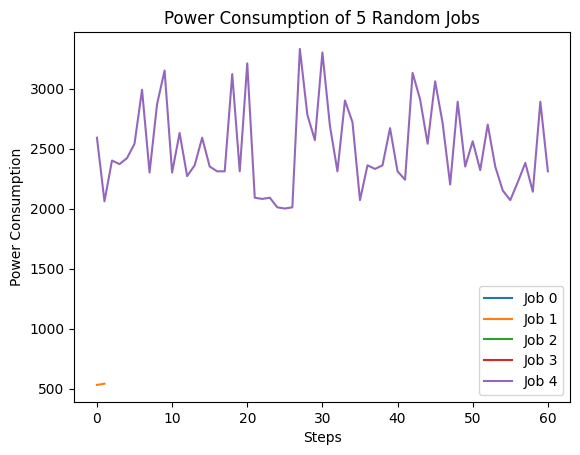

In [8]:
# Plot 5 random jobs' power consumption
df_plot = df.sample(n = 5)
df_plot["x"] = df_plot["node_power_consumption"].apply(lambda x: list(range(len(x))))
for i in range(len(df_plot)):
    plt.plot(df_plot["x"].iloc[i], df_plot["node_power_consumption"].iloc[i], label = f"Job {i}")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Power Consumption")
plt.title("Power Consumption of 5 Random Jobs")
plt.show()

#### Normalization

For our purposes we want to inspect only the average power consumption per job

In [9]:
# Creation of an additional feature
df["average_power_consumption"] = df["node_power_consumption"].apply(lambda x: np.mean(x))
df["average_power_consumption"]

,average_power_consumption
0,8318.888889
1,8164.827586
2,8193.111111
3,630.377358
4,860.208333
...,...
231233,920.000000
231234,863.000000
231235,877.745455
231236,860.000000


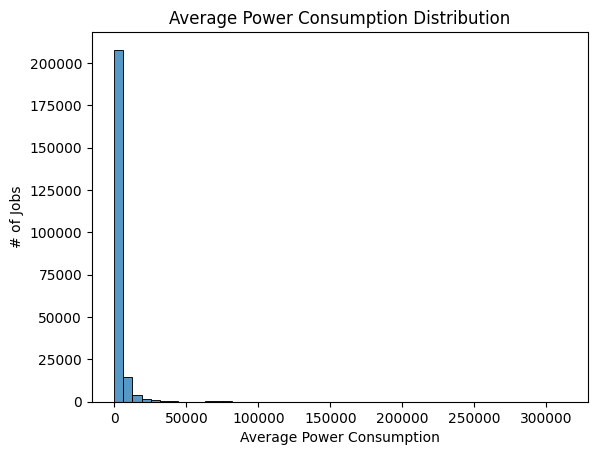

In [10]:
sns.histplot(data = df["average_power_consumption"].values, bins = 50, kde = False)
plt.title("Average Power Consumption Distribution")
plt.ylabel("# of Jobs")
plt.xlabel("Average Power Consumption")
# plt.yscale("log")
plt.show()

Since the values are in a very large range we can further normalize the average power consumption. Since jobs run on different number of nodes, we can characterize the jobs based on its performance on a single node, hence we normalize the power consumption on the # of nodes allocated to each job

In [11]:
# Normalization
df["norm_average_power_consumption"] = df["average_power_consumption"] / df["num_nodes_alloc"]
df["norm_average_power_consumption"]

,norm_average_power_consumption
0,519.930556
1,510.301724
2,512.069444
3,630.377358
4,860.208333
...,...
231233,920.000000
231234,863.000000
231235,877.745455
231236,860.000000


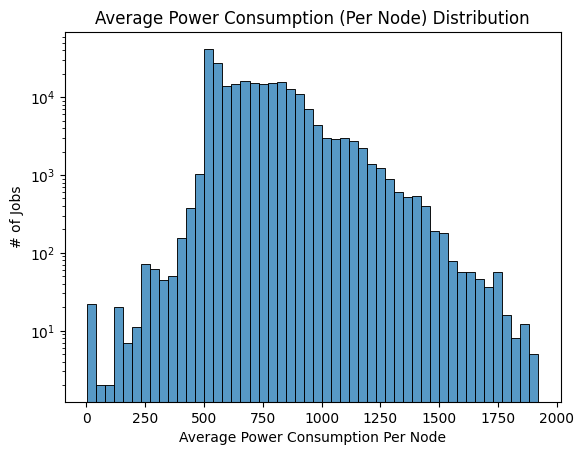

In [12]:
sns.histplot(data = df["norm_average_power_consumption"].values, bins = 50, kde = False)
plt.title("Average Power Consumption (Per Node) Distribution")
plt.ylabel("# of Jobs")
plt.xlabel("Average Power Consumption Per Node")
plt.yscale("log")
plt.show()

## Data Clustering

### Job Characterization

In order to perform analysis and characterize the jobs based on their per-node power consumption, we can divide them into categories through clustering techniques. For our experiments we will be using the **K-Means** and the **DBSCAN**

#### DBSCAN

**DBSCAN** is a popular **density-based** clustering algorithm used in machine learning. Unlike algorithms like **K-Means**, DBSCAN does not require the number of clusters to be specified in advance. Instead, it forms clusters based on the density of points in a region, marking regions of low density as **outliers** or **noise**.

### Key Concepts:
- **Core Points**: Points that have a sufficient number of neighboring points within a given radius (`eps`).
- **Border Points**: Points that are within the `eps` radius of a core point but do not have enough neighbors themselves to be considered core points.
- **Noise Points**: Points that do not belong to any cluster because they do not meet the criteria of being close enough to core points.

DBSCAN is effective for finding clusters of arbitrary shapes, making it a versatile choice for various datasets.

In [13]:
from sklearn.cluster import DBSCAN

In [14]:
dbscan = DBSCAN()
df["cluster_db"] = dbscan.fit_predict(df["norm_average_power_consumption"].values.reshape(-1, 1))

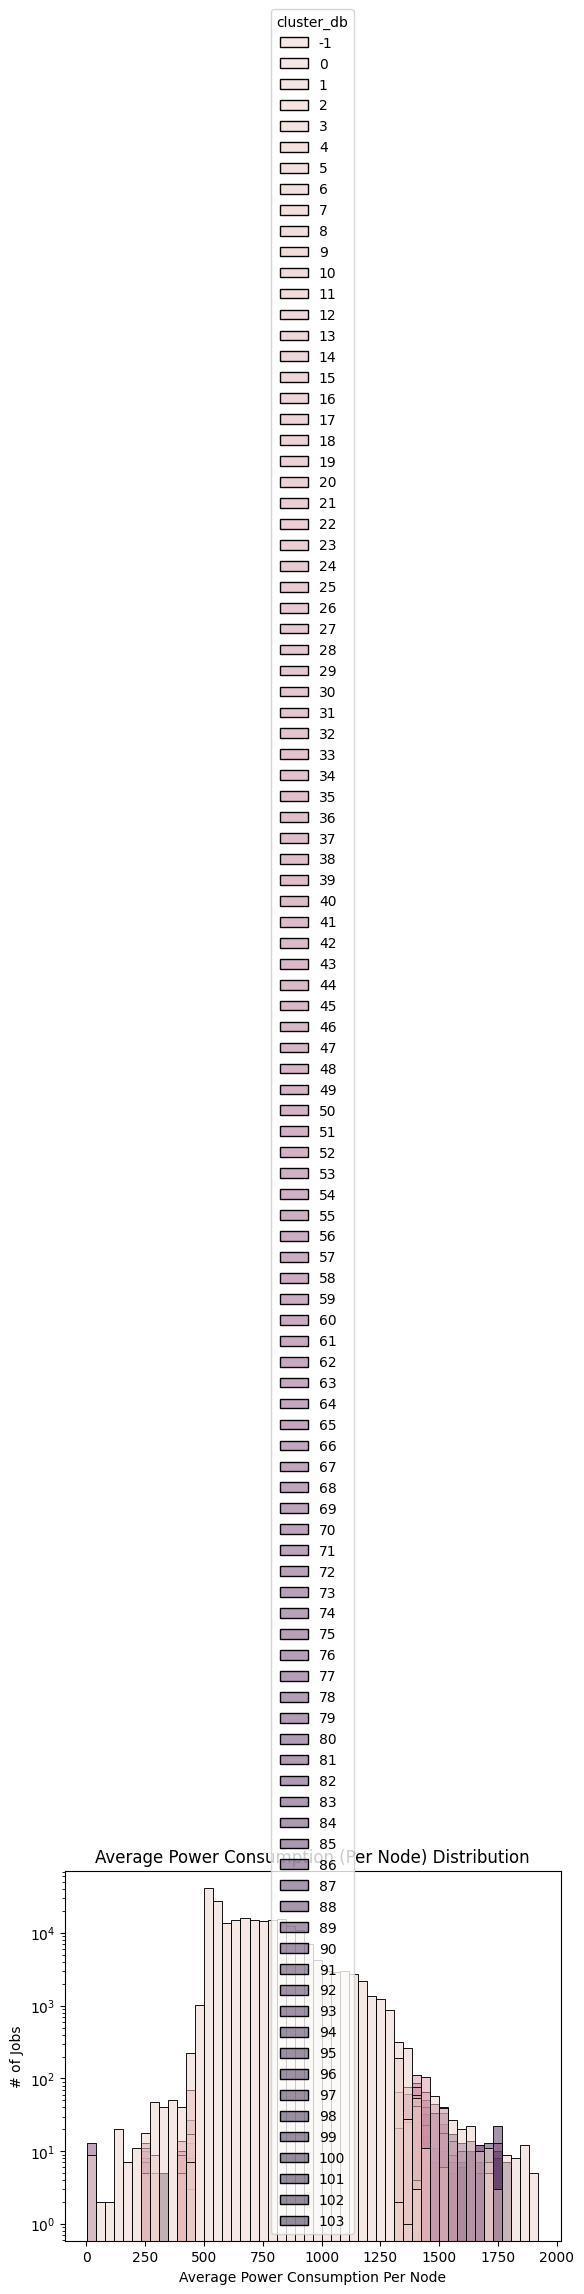

In [15]:
sns.histplot(data = df, x = "norm_average_power_consumption", bins = 50, kde = False, hue = "cluster_db")
plt.title("Average Power Consumption (Per Node) Distribution")
plt.ylabel("# of Jobs")
plt.xlabel("Average Power Consumption Per Node")
plt.yscale("log")
plt.show()

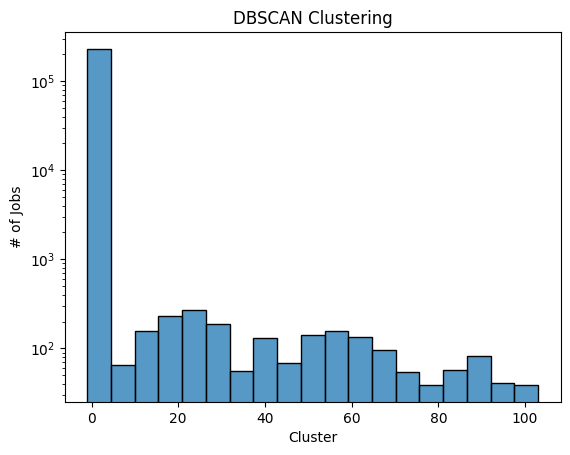

In [16]:
sns.histplot(data = df, x = "cluster_db")
plt.xlabel("Cluster")
plt.ylabel("# of Jobs")
plt.title("DBSCAN Clustering")
plt.yscale("log")
plt.show()

#### K-Means

### K-Means Clustering

**K-Means** is one of the most widely used **partitioning-based** clustering algorithms. It aims to divide a dataset into a predefined number of clusters (K) by assigning each data point to the nearest cluster center (centroid). The algorithm iteratively refines the centroids to minimize the **within-cluster sum of squared distances** (inertia).

### Key Concepts:
- **Centroids**: The center points of each cluster, computed as the mean of the data points assigned to that cluster.
- **Clusters**: Groups of data points that are closer to the same centroid than to any other centroid.
- **Iterations**: The algorithm repeatedly updates the centroids by moving them to the average position of the points in the cluster until convergence (no significant changes in centroid positions).

K-Means is effective when clusters are roughly spherical and evenly sized, but it requires the number of clusters (K) to be specified beforehand, which can be a limitation.

### Steps:
1. Initialize K centroids randomly.
2. Assign each data point to the nearest centroid.
3. Recalculate the centroids based on the mean of the points in each cluster.
4. Repeat the assignment and centroid update steps until the centroids no longer change significantly.


##### Elbow Method

In order to find the optimal number of clusters (i.e., $k$) for the K-Means, we can rely on the Elbow Method. Such method analyzes the inertia (sum of squared distances from points to cluster centers) to determine which is the $k$ after which the inertia starts decreasing at a slower rate.

In [17]:
from sklearn.cluster import KMeans
!pip3 install kneed
from kneed import KneeLocator

In [18]:
def elbow_method(data, clustering_method, k_min, k_max):
  # Store the sum of squared distances (inertia)
  inertia = []

  k_values = list(range(k_min, k_max + 1))

  # Compute K-Means clustering for each value of K
  for k in k_values:
    kmeans = clustering_method(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)  # Store inertia (sum of squared distances)

  kneedle = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")

  # Plot the Elbow curve
  plt.figure(figsize=(8, 5))
  plt.plot(k_values, inertia, marker="o", linestyle="--")

  # Draw a vertical line at optimal k
  optimal_k = kneedle.knee
  plt.axvline(x=optimal_k, color='red', linestyle='--', label="Optimal k")

  plt.legend()
  plt.xlabel("Number of Clusters (K)")
  plt.ylabel("Inertia (Sum of Squared Distances)")
  plt.title("Elbow Method for Optimal K")
  plt.xticks(k_values)

  # Show the plot
  plt.show()
  # Return optimal k
  return optimal_k

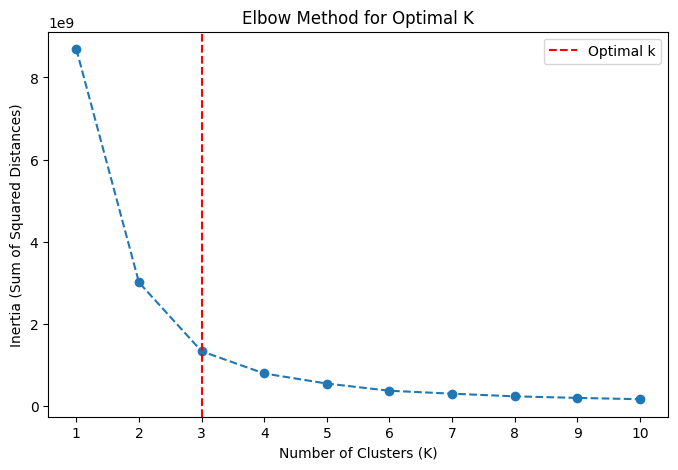

In [19]:
opt_k = elbow_method(data = df["norm_average_power_consumption"].values.reshape(-1, 1), clustering_method = KMeans, k_min = 1, k_max = 10)

In [20]:
# Generate the clusters
kmeans = KMeans(n_clusters=opt_k, random_state=42)
df["cluster"] = kmeans.fit_predict(df["norm_average_power_consumption"].values.reshape(-1, 1))

Let's now see how the data are split by the K-Means.

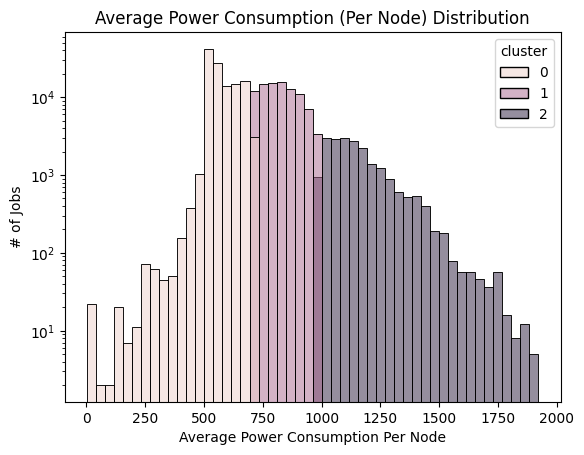

In [21]:
sns.histplot(data = df, x = "norm_average_power_consumption", bins = 50, kde = False, hue = "cluster")
plt.title("Average Power Consumption (Per Node) Distribution")
plt.ylabel("# of Jobs")
plt.xlabel("Average Power Consumption Per Node")
plt.yscale("log")
plt.show()

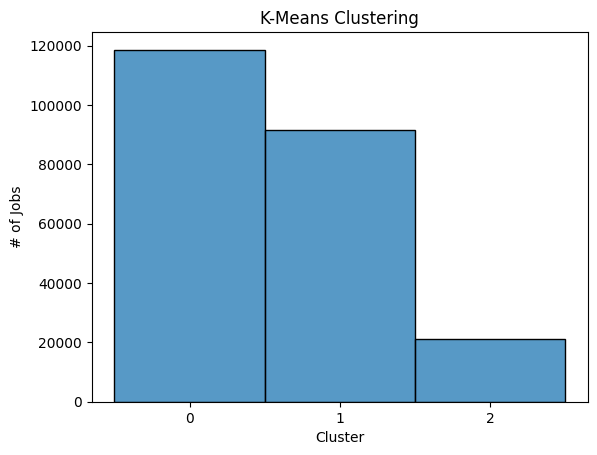

In [22]:
df["cluster"] = df.cluster.astype(str)
sns.histplot(data = df, x = "cluster")
plt.xlabel("Cluster")
plt.ylabel("# of Jobs")
plt.title("K-Means Clustering")
plt.show()

#### Considerations

With the **K-Means** the labels are cleaner and they make more sense, as the cluster labels divide the jobs into "low", "medium" and "high" power consuming jobs.

## ML Predictive Modelling

In this section we will see how to use several ML models to perform prediction on the data.
We will showcase how to use ML models to perform regression and classification tasks. For the regression, we will predict the raw power consumption values; while for the classification we will predict the labels created through the K-Means.

### Data Split and Preparation for Modelling

In order to perform prediction tasks, we need to prepare the data for the models. This includes defining the target values, the input features and splitting the data into training and test set.

#### Target Values

In [23]:
y_regression = df["norm_average_power_consumption"].values
y_classification = df["cluster"].values

#### Input Features

### Selecting Input Features for a Tabular Prediction Task

Selecting the right input features is crucial for building an effective machine learning model for a tabular prediction task. The goal is to choose features that are most informative and relevant to the prediction target, while minimizing noise and redundancy.

### Steps for Feature Selection:

1. **Domain Knowledge**:
   - Leverage your understanding of the problem domain to select features that are likely to be important for the target variable.

2. **Correlation Analysis**:
   - Use correlation matrices to identify and remove highly correlated features. Features that are highly correlated with each other can introduce multicollinearity, leading to less stable models.

3. **Feature Importance**:
   - Use models like **Random Forest** or **Gradient Boosting** to calculate feature importance scores. These models can help identify which features contribute the most to the prediction.

4. **Statistical Methods**:
   - Perform statistical tests (e.g., chi-squared test for categorical features, ANOVA for continuous features) to assess the relationship between each feature and the target variable.

5. **Dimensionality Reduction**:
   - Techniques like **Principal Component Analysis (PCA)** or **t-SNE** can help reduce the feature space, especially when dealing with high-dimensional datasets, while retaining the most important variance.

6. **Feature Engineering**:
   - Consider creating new features from existing ones. For example, combining categorical features or extracting new insights from continuous variables can improve model performance.

7. **Remove Redundant Features**:
   - Drop irrelevant or redundant features that do not add predictive value to the model or may increase overfitting.

### Considerations:
- Always keep track of how changes to feature selection impact model performance through cross-validation or separate validation datasets.
- Be mindful of the risk of **overfitting** when using too many features, especially when dealing with limited data.

By following these steps, you can identify the most valuable features for your prediction task and improve the accuracy and efficiency of your model.


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231238 entries, 0 to 231237
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   cores_alloc_layout              231238 non-null  object             
 1   cores_allocated                 231238 non-null  object             
 2   cores_per_task                  231238 non-null  int64              
 3   derived_ec                      231238 non-null  object             
 4   eligible_time                   231238 non-null  datetime64[us, UTC]
 5   end_time                        231238 non-null  datetime64[us, UTC]
 6   group_id                        231238 non-null  int64              
 7   job_id                          231238 non-null  int64              
 8   job_state                       231238 non-null  object             
 9   nodes                           231238 non-null  object             
 

In [25]:
# Calculate the correlation matrix
eligible_features = ["group_id", "job_state", "num_nodes_alloc", "num_cores_alloc", "num_tasks", "partition", "qos", "run_time", "shared", "threads_per_core", "time_limit", "num_gpus_alloc", "mem_alloc", "user_id"]

for feat in eligible_features:
  df[feat] = df[feat].astype("category").cat.codes

targets = ["cluster", "norm_average_power_consumption"]

corr_matrix = df[eligible_features + targets].corr()

# Display the correlation matrix
print(corr_matrix[targets])


                                 cluster  norm_average_power_consumption
group_id                       -0.012548                       -0.014355
job_state                       0.041135                        0.037670
num_nodes_alloc                -0.030178                       -0.053845
num_cores_alloc                 0.036306                        0.006908
num_tasks                      -0.001884                       -0.017211
partition                       0.020819                        0.019434
qos                             0.013844                       -0.000947
run_time                        0.185240                        0.192947
shared                          0.129285                        0.143739
threads_per_core               -0.019520                       -0.019003
time_limit                      0.215649                        0.235887
num_gpus_alloc                 -0.014641                       -0.037854
mem_alloc                      -0.000156           

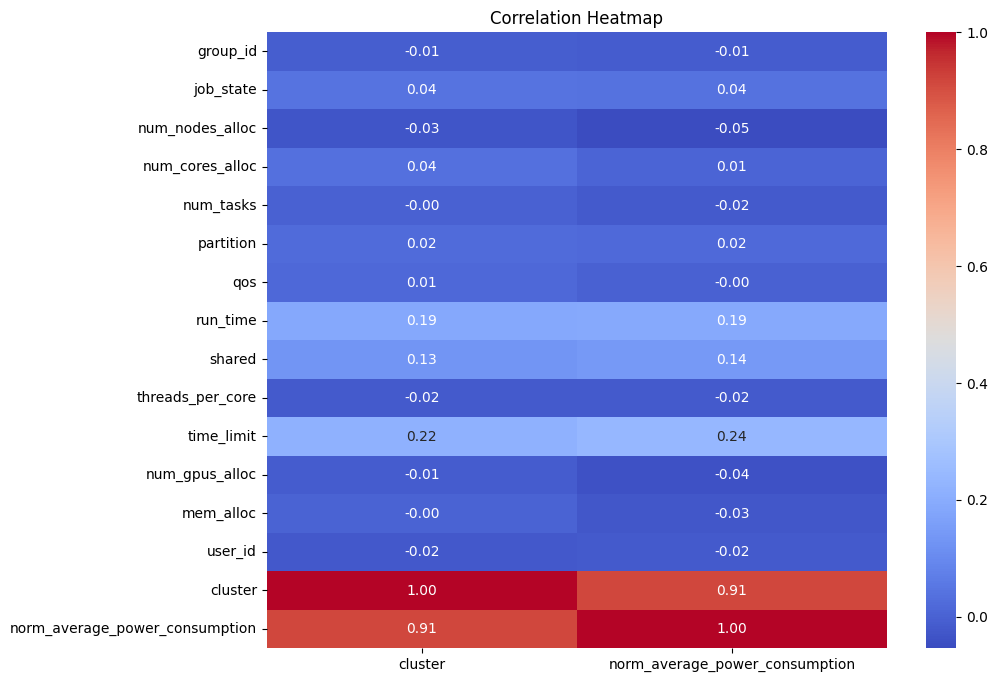

In [26]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[targets], annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
# We pick the features which are more correlated to the targets
feature_set = ["job_state", "num_cores_alloc", "partition", "qos", "run_time", "shared", "time_limit"]

#### Data Normalization

Data normalization is a crucial preprocessing step in machine learning, especially when using algorithms that are sensitive to the scale of the input features, such as **K-Nearest Neighbors**, **Support Vector Machines**, and **Neural Networks**. Normalization transforms the features of the dataset into a standard scale, ensuring that no feature dominates over others due to differences in magnitude or units. Common methods include **Min-Max Scaling**, which scales the data to a range between 0 and 1, and **Standardization**, which rescales the data to have a mean of 0 and a standard deviation of 1. Properly normalized data can significantly improve the performance and convergence of machine learning models, helping them to make more accurate predictions.

For this example, we will be using the Min-Max scailing.




In [28]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Create the vector of the input features
x = scaler.fit_transform(df[feature_set].values)

In [29]:
x

array([[0.00000000e+00, 6.37795276e-01, 5.00000000e-01, ...,
        2.83774237e-02, 0.00000000e+00, 4.63976945e-01],
       [0.00000000e+00, 6.37795276e-01, 5.00000000e-01, ...,
        4.54117278e-02, 0.00000000e+00, 4.63976945e-01],
       [0.00000000e+00, 6.37795276e-01, 5.00000000e-01, ...,
        3.45788523e-02, 0.00000000e+00, 4.63976945e-01],
       ...,
       [2.00000000e-01, 2.44094488e-01, 5.00000000e-01, ...,
        2.14498783e-01, 5.00000000e-01, 7.03170029e-01],
       [2.00000000e-01, 2.44094488e-01, 5.00000000e-01, ...,
        7.84990973e-05, 5.00000000e-01, 1.00000000e+00],
       [2.00000000e-01, 2.44094488e-01, 5.00000000e-01, ...,
        1.17748646e-04, 5.00000000e-01, 1.00000000e+00]])

#### Data Splitting

We split the data into training and test set, following a 70/30 proportion.

In [77]:
from sklearn.model_selection import train_test_split

test_size = 0.3

# Subsampling if the computation is too heavy on the resources
subsampling_ratio = 0.5 # set to 1 if not needed
subsampling_elem = int(len(df) * subsampling_ratio)

# Split the data into training and testing sets (70% training, 30% testing)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x[:subsampling_elem], y_regression[:subsampling_elem], test_size=test_size, random_state=42)
x_train_clas, x_test_clas, y_train_class, y_test_clas = train_test_split(x[:subsampling_elem], y_classification[:subsampling_elem], test_size=test_size, random_state=42)

### Modeling

We demonstrate how to perform regression and classification tasks with different ML models, such as the Linear Regression, Decision Tree, Random Forest, Support Vector Machine and the K-Nearest Neighbors.

#### Overview of Machine Learning Algorithms

- **Linear Regression**: Linear regression is a simple statistical model that establishes a relationship between input features and a continuous target variable. It assumes that the relationship between the features and the target is linear, and it aims to minimize the sum of squared errors between the predicted and actual values.
  
- **Decision Tree**: A decision tree is a hierarchical model that splits the dataset into subsets based on feature values, forming a tree-like structure. Each internal node represents a feature, and each leaf node represents a predicted output. It is easy to interpret but can suffer from overfitting.

- **Random Forest**: A random forest is an ensemble method that creates multiple decision trees by bootstrapping data samples and using random subsets of features for each tree. The final prediction is made by averaging the outputs of all trees, reducing overfitting and improving accuracy compared to a single decision tree.

- **Support Vector Machine (SVM)**: SVM is a supervised learning algorithm used for classification and regression tasks. It works by finding the hyperplane that best separates data points of different classes. For regression, it tries to fit the best possible line while maximizing the margin between the line and the data points.

- **K-Nearest Neighbors (KNN)**: KNN is a simple, non-parametric algorithm that classifies data points based on the majority label of their nearest neighbors. It computes the distance between data points and assigns a label to a point based on the labels of its K closest neighbors, making it highly intuitive but computationally expensive for large datasets.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, f1_score, accuracy_score, mean_absolute_percentage_error

#### Regression Task

In [ ]:
# Initialize the models
models = {
    'Linear Regression': LinearRegression(n_jobs = -1),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(n_jobs = -1),
    'Support Vector Regressor': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_jobs = -1)
}

# Train, predict, and evaluate each model
results = []

for name, model in models.items():
  # Fit the model
  model.fit(x_train_reg, y_train_reg)

  # Make predictions
  y_pred_reg = model.predict(x_test_reg)

  # Calculate evaluation metrics
  mae = mean_absolute_error(y_test_reg, y_pred_reg)
  mse = mean_squared_error(y_test_reg, y_pred_reg)
  mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)
  r2 = r2_score(y_test_reg, y_pred_reg)

  # Store the results
  results.append({
      'Model': name,
      'MAE': mae,
      'MAPE': mape,
      'MSE': mse,
      'R2': r2
  })

# Create a DataFrame to display the results
results_df_reg = pd.DataFrame.from_records(results)
print(results_df_reg)

#### Visualization of the results

We plot the results to help evaluation

<ipython-input-74-441b6d47e610>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-74-441b6d47e610>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-74-441b6d47e610>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-74-441b6d47e610>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


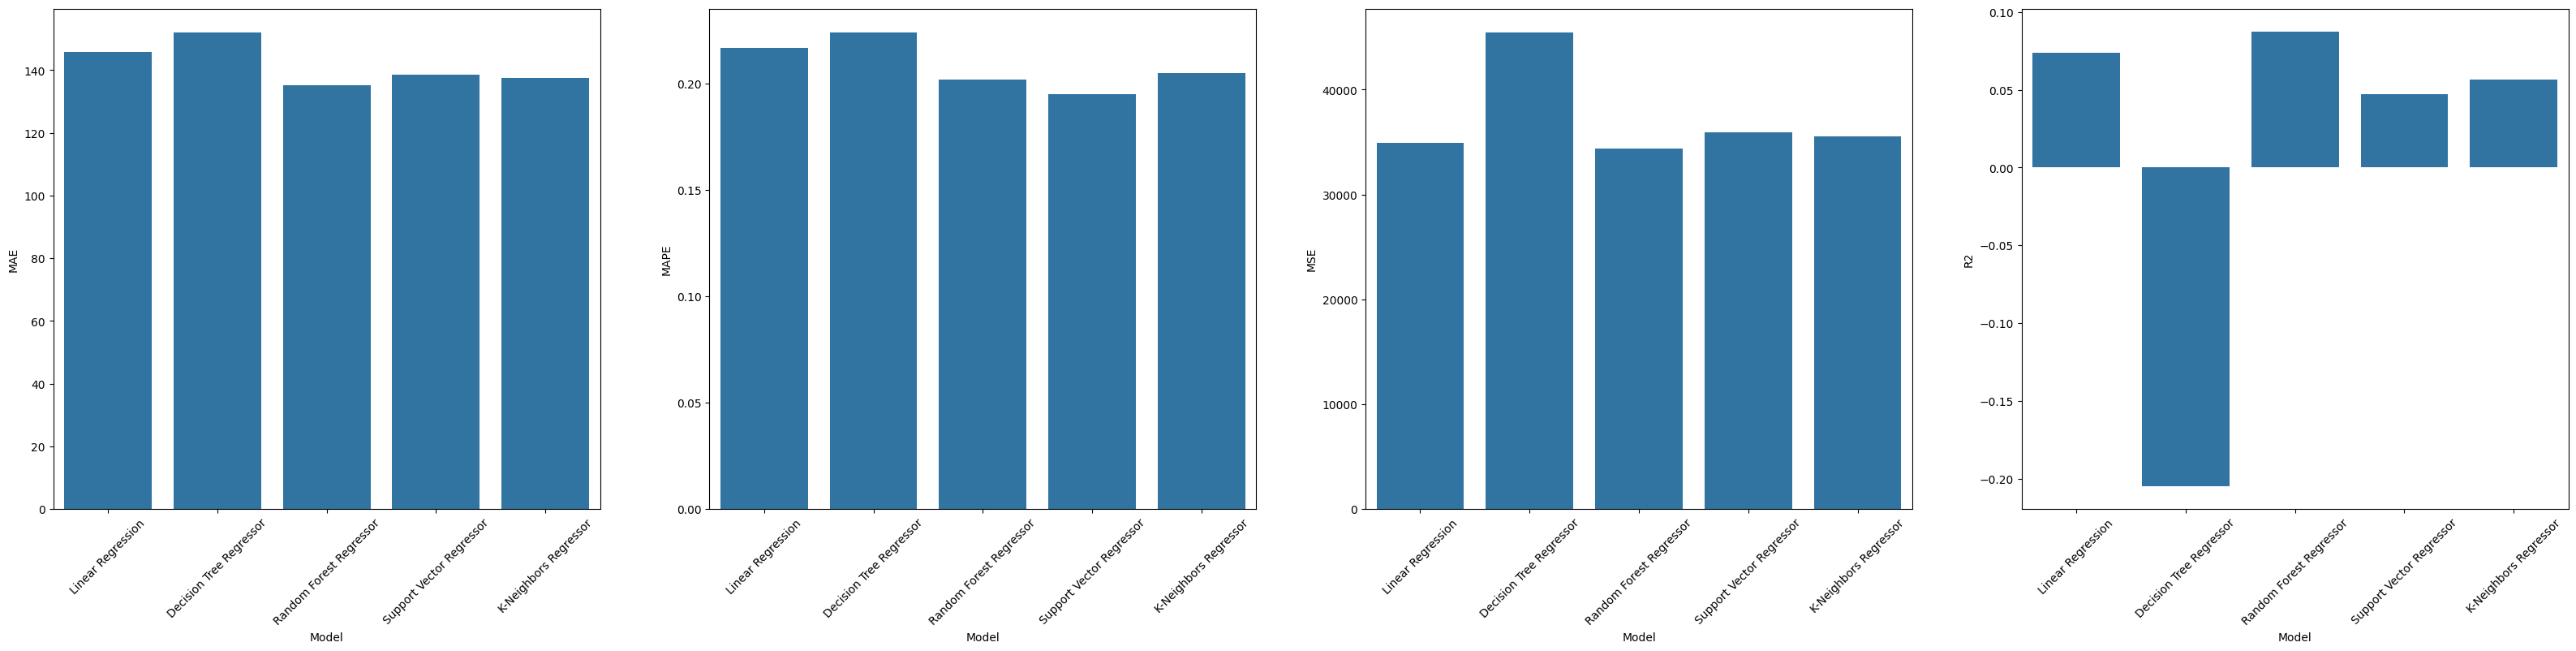

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(40, 8))
axes = axes.flatten()
metrics = ["MAE", "MAPE", "MSE", "R2"]

for i in range(len(metrics)):
  ax = axes[i]
  metric = metrics[i]
  sns.barplot(data = results_df_reg, x = "Model", y = metric, ax = ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

#### Classification Task

In [75]:
# Initialize the models
models = {
    'Decision Tree Regressor': DecisionTreeClassifier(),
    'Random Forest Regressor': RandomForestClassifier(n_jobs = -1),
    'Support Vector Regressor': SVC(),
    'K-Neighbors Regressor': KNeighborsClassifier(n_jobs = -1)
}

# Train, predict, and evaluate each model
results = []

for name, model in models.items():
  # Fit the model
  model.fit(x_train_clas, y_train_clas)

  # Make predictions
  y_pred_clas = model.predict(x_test_clas)

  # Calculate evaluation metrics
  f1 = f1_score(y_test_clas, y_pred_clas, average = "macro")
  accuracy = accuracy_score(y_test_clas, y_pred_clas)
  cr = classification_report(y_test_clas, y_pred_clas)

  print(f"Classification Report of {name}:\n{cr}")

  # Store the results
  results.append({
      'Model': name,
      'F1': f1,
      'Accuracy': accuracy
  })

# Create a DataFrame to display the results
results_df_clas = pd.DataFrame.from_records(results)
print(results_df_clas)

Classification Report of Decision Tree Regressor:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      3613
           1       0.52      0.55      0.53      2704
           2       0.26      0.17      0.20       620

    accuracy                           0.57      6937
   macro avg       0.48      0.46      0.46      6937
weighted avg       0.56      0.57      0.57      6937

Classification Report of Random Forest Regressor:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      3613
           1       0.53      0.59      0.56      2704
           2       0.29      0.16      0.20       620

    accuracy                           0.59      6937
   macro avg       0.50      0.47      0.48      6937
weighted avg       0.58      0.59      0.58      6937

Classification Report of Support Vector Regressor:
              precision    recall  f1-score   support

           0       0.63      0.7

<ipython-input-76-88fd92f1cda5>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-76-88fd92f1cda5>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


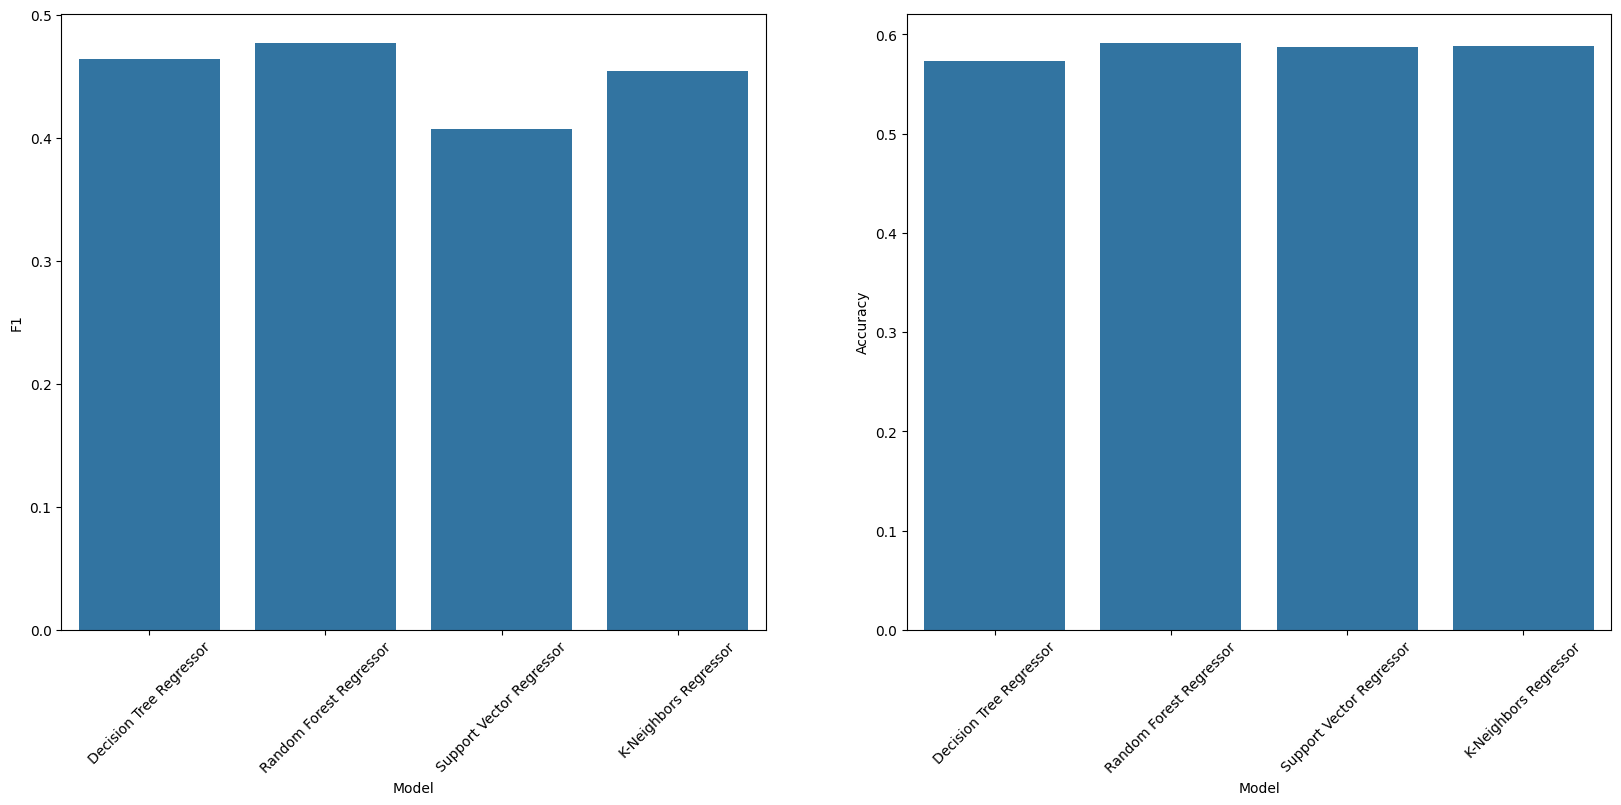

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes = axes.flatten()
metrics = ["F1", "Accuracy"]

for i in range(len(metrics)):
  ax = axes[i]
  metric = metrics[i]
  sns.barplot(data = results_df_clas, x = "Model", y = metric, ax = ax)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()